In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from ultralytics import YOLO
import  math
import csv
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import os
import chess
import chess.svg


<br>

#### Display Image

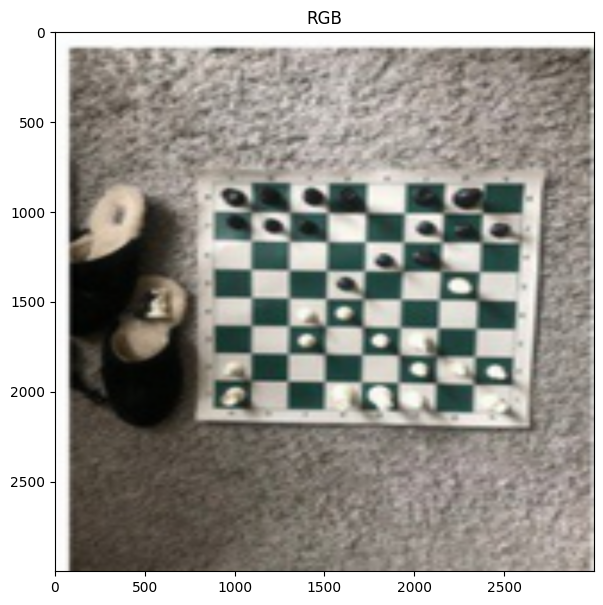

In [ ]:
# Path of Image that you want to convert
image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\0\G000_IMG014.jpg"
image_path = r"C:\Users\Alessandro\Downloads\photo_5879853732403989244_y.jpg"
# image_path = r"C:\Users\Alessandro\Downloads\photo_5879853732403989239_y.jpg"
# image_path = r"C:\Users\Alessandro\Downloads\photo_5879853732403989238_y.jpg"

# read image and convert it to different color spaces 
image = cv2.imread(image_path)
image = cv2.resize(image, (3000, 3000))

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

original_size = 1000
scale_factor = image.shape[0] / original_size

plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

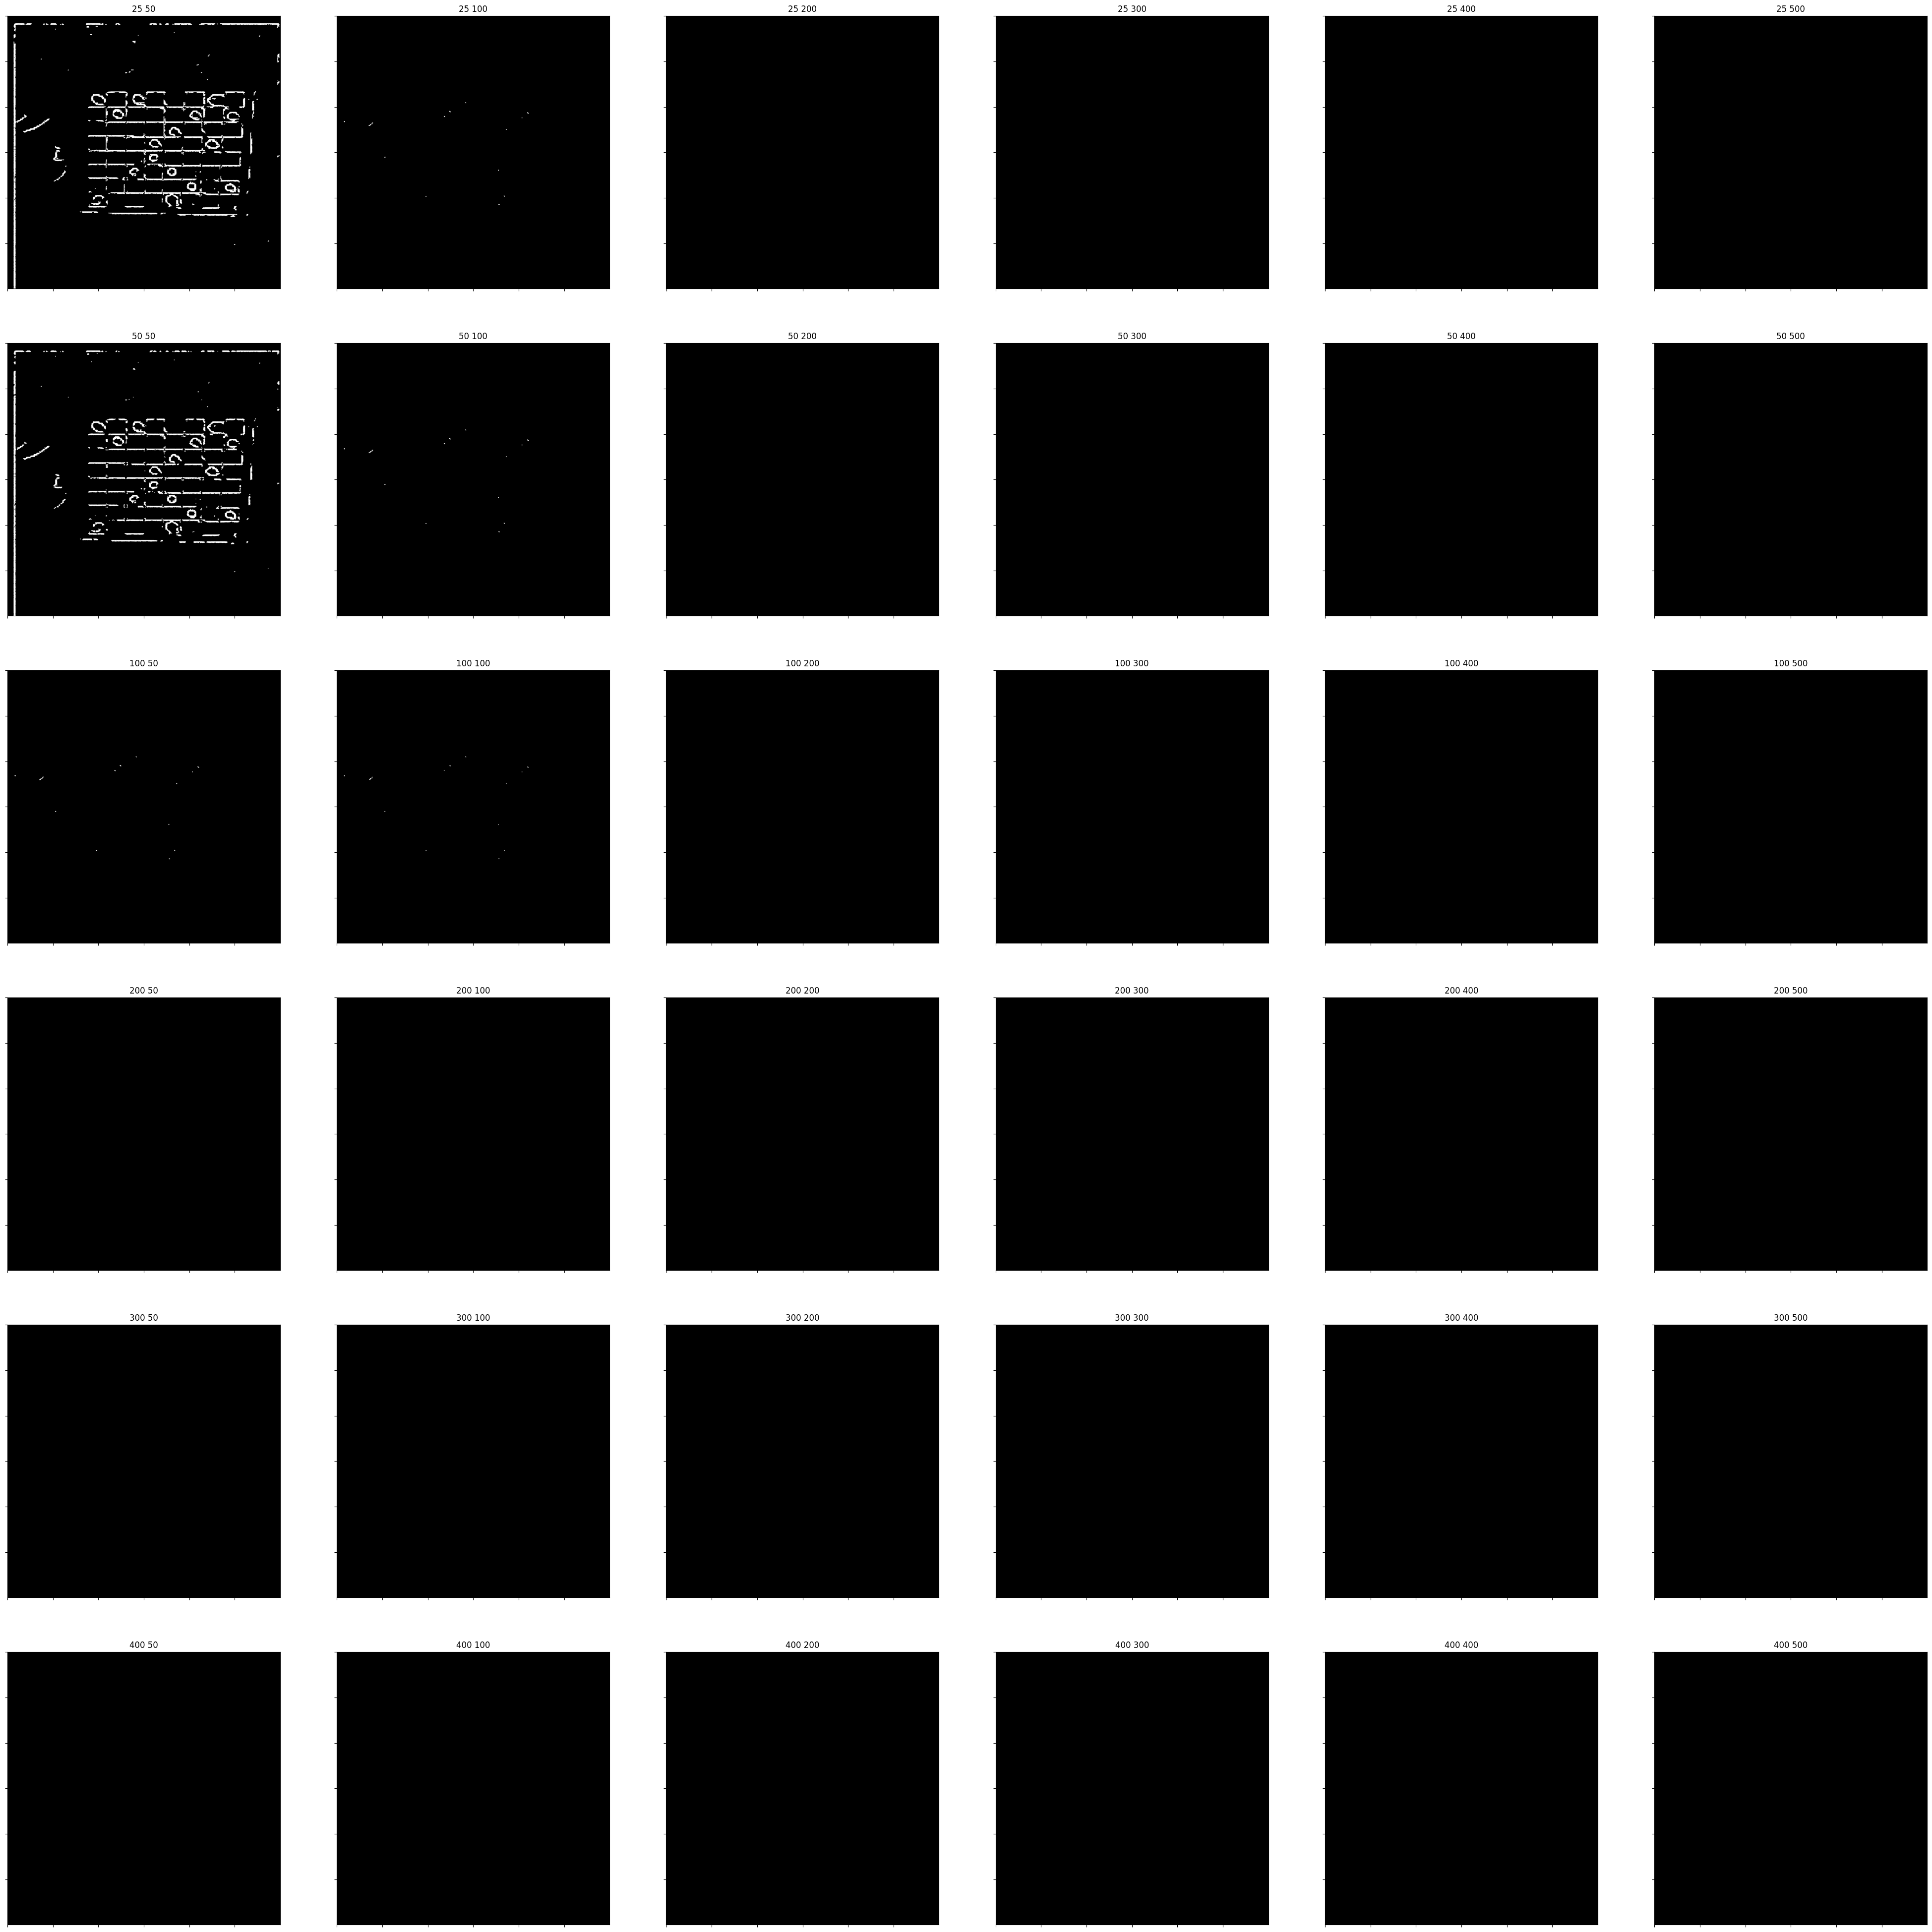

In [140]:
import itertools

t1 = [25, 50, 100, 200, 300, 400]
t2 = [50, 100, 200, 300, 400, 500]

params = [x for x in itertools.product(t1, t2)]
cannies_images = []

blurred_image = cv2.GaussianBlur(gray_image,(5,5),0)
can_kernel = np.ones((7, 7), np.uint8)

rows = len(t1)
cols = len(t2)
plt.figure(figsize=(50,50))
for idx, (t1, t2) in enumerate(params):
    can = cv2.Canny(blurred_image, t1, t2) # é stato modificato questo input per creare le varie immagini
    can = cv2.dilate(can, can_kernel, iterations=1)
    cannies_images.append(can)

    ax = plt.subplot(rows, cols, idx + 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(f'{t1} {t2}')
    plt.imshow(can, cmap='gray')


In [141]:
hough_images = []

kernel = np.ones((3, 3), np.uint8)

# plt.figure(figsize=(50,50))
for idx, (t1,t2) in enumerate(params):
    can = cannies_images[idx]

    # Hough Lines
    lines = cv2.HoughLinesP(can, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)
    # lines = link_and_merge_segments_array(lines[:, 0], image.shape[0]*image.shape[1])

    # Create an image that contains only black pixels
    black_image = np.zeros_like(can)

    # Draw only lines that are output of HoughLinesP function to the "black_image"
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # draw only lines to the "black_image"
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 3)

    # Dilation
    black_image = cv2.dilate(black_image, kernel, iterations=1)
    hough_images.append(black_image)

    # ax = plt.subplot(rows, cols, idx + 1)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # plt.title(f'{t1} {t2}')
    # plt.imshow(black_image, cmap='gray')

In [142]:
best_valid_square_image = None
best_valid_square_image_square_count = 0
best_t1, best_t2 = 0,0
best_square_approx = []

for idx, (t1,t2) in enumerate(params):
    black_image = hough_images[idx]
    current_valid_square_count = 0

    # Look for valid squares and check if squares are inside of board
    board_contours = []
    square_approx = []
    valid_squares_image = np.zeros_like(black_image)

    # find contours
    board_contours, hierarchy = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    # loop through contours and filter them by deciding if they are potential squares

    for contour in board_contours:
        if 4000*scale_factor < cv2.contourArea(contour) < 20000*scale_factor:
            # Approximate the contour to a simpler shape
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
                
            if len(approx) == 4:
                # 4 points of polygon
                pts = [pt[0].tolist() for pt in approx]
                # pts = approx[0]

                # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

                #  Y values
                if index_sorted[0][1]< index_sorted[1][1]:
                    cur=index_sorted[0]
                    index_sorted[0] =  index_sorted[1]
                    index_sorted[1] = cur

                if index_sorted[2][1]> index_sorted[3][1]:
                    cur=index_sorted[2]
                    index_sorted[2] =  index_sorted[3]
                    index_sorted[3] = cur

                # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                pt1=index_sorted[0]
                pt2=index_sorted[1]
                pt3=index_sorted[2]
                pt4=index_sorted[3]

                # find rectangle that fits 4 point 
                x, y, w, h = cv2.boundingRect(contour)
                # find center of rectangle 
                center_x=(x+(x+w))/2
                center_y=(y+(y+h))/2

                # calculate length of 4 side of rectangle
                l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
                l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
                l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
                l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)

                # Create a list of lengths
                lengths = [l1, l2, l3, l4]
                
                # Get the maximum and minimum lengths
                max_length = max(lengths)
                min_length = min(lengths)

                # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,  
                if (max_length - min_length) <= 50 * scale_factor: # 20 for smaller boards  , 50 for bigger , 35 works most of the time 
                    valid_square=True
                else:
                    valid_square=False

                if valid_square:
                    current_valid_square_count += 1 

                    square_approx.append(approx)

                    # Draw only valid squares to "valid_squares_image"
                    cv2.line(valid_squares_image, pt1, pt2, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt2, pt3, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt3, pt4, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt1, pt4, (255, 255, 0), 7)

    if current_valid_square_count > best_valid_square_image_square_count:
        best_valid_square_image = valid_squares_image
        best_valid_square_image_square_count = current_valid_square_count
        best_t1, best_t2 = t1, t2
        best_square_approx = square_approx

if best_valid_square_image is None:
    raise ValueError("No best square image found")

plt.figure(figsize=(5,5))
plt.title(f'{best_t1} {best_t2}')
plt.imshow(best_valid_square_image, cmap='gray')
plt.show()

ValueError: No best square image found

In [ ]:
import cv2
import numpy as np

def extract_features(approx):
    # Centroid
    M = cv2.moments(approx)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Size (area or bounding box)
    area = cv2.contourArea(approx)
    rect = cv2.minAreaRect(approx)
    width, height = rect[1]
    angle = rect[2]  # Angle of rotation

    # Normalize angle if necessary
    if width < height:
        angle = angle + 90

    return {
        "centroid": (cx, cy),
        "area": area,
        "angle": angle,
        "size": max(width, height) * min(width, height)  # approximate area
    }


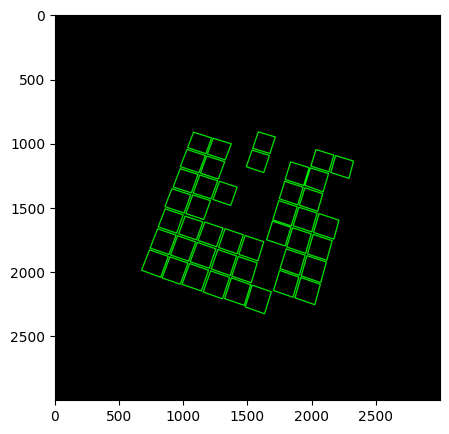

In [ ]:
import numpy as np
from scipy.stats import zscore

# features is a list of dicts from extract_features()
features = [extract_features(x) for x in best_square_approx]
centroids = np.array([f["centroid"] for f in features])
areas = np.array([f["area"] for f in features])
angles = np.array([f["angle"] for f in features])
sizes = np.array([f["size"] for f in features])

# Use z-score for outlier detection
area_z = np.abs(zscore(areas))
angle_z = np.abs(zscore(angles))
size_z = np.abs(zscore(sizes))

# Distance of centroids from cluster center
center = np.mean(centroids, axis=0)
dists = np.linalg.norm(centroids - center, axis=1)
dist_z = np.abs(zscore(dists))

# Define threshold (commonly 2 or 3)
threshold = 3

valid_indices = np.where((area_z < threshold) &
                         (angle_z < threshold) &
                         (size_z < threshold) &
                         (dist_z < threshold))[0]

valid_polygons = [best_square_approx[i] for i in valid_indices]


# SHOW RESULT

valid_polygons_image = rgb_image= cv2.cvtColor(best_valid_square_image,cv2.COLOR_GRAY2BGR)
for approx in valid_polygons:
        pts = [pt[0].tolist() for pt in approx]
        # pts = approx[0]

        # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
        index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

        #  Y values
        if index_sorted[0][1]< index_sorted[1][1]:
            cur=index_sorted[0]
            index_sorted[0] =  index_sorted[1]
            index_sorted[1] = cur

        if index_sorted[2][1]> index_sorted[3][1]:
            cur=index_sorted[2]
            index_sorted[2] =  index_sorted[3]
            index_sorted[3] = cur

        # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
        pt1=index_sorted[0]
        pt2=index_sorted[1]
        pt3=index_sorted[2]
        pt4=index_sorted[3]

        # Draw only valid squares to "valid_squares_image"
        cv2.line(valid_polygons_image, pt1, pt2, (0, 255, 0), 7)
        cv2.line(valid_polygons_image, pt2, pt3, (0, 255, 0), 7)
        cv2.line(valid_polygons_image, pt3, pt4, (0, 255, 0), 7)
        cv2.line(valid_polygons_image, pt1, pt4, (0, 255, 0), 7)

plt.figure(figsize=(5,5))
plt.imshow(valid_polygons_image)
plt.show()

In [ ]:
# avg_angle = np.mean([f["angle"] for f in features])  # from previous step

# def rotate_point(point, angle_deg, center):
#     angle_rad = np.deg2rad(angle_deg)
#     rot_matrix = np.array([
#         [np.cos(angle_rad), -np.sin(angle_rad)],
#         [np.sin(angle_rad),  np.cos(angle_rad)]
#     ])
#     return np.dot(rot_matrix, (point - center)) + center

# centroids = np.array([f["centroid"] for f in features])
# center = np.mean(centroids, axis=0)

# # Rotate centroids to align with axes
# rotated_points = np.array([rotate_point(p, -avg_angle, center) for p in centroids])

# x_min, y_min = np.min(rotated_points, axis=0)
# x_max, y_max = np.max(rotated_points, axis=0)

# # Calculate width and height
# w = x_max - x_min
# h = y_max - y_min

# # Make it square by expanding the smaller side
# size = max(w, h)

# # Center of the square in rotated space
# square_center = np.array([(x_min + x_max) / 2, (y_min + y_max) / 2])

# # create square points in rotated space
# half_size = size / 2
# square_pts = np.array([
#     [-half_size, -half_size],
#     [ half_size, -half_size],
#     [ half_size,  half_size],
#     [-half_size,  half_size]
# ]) + square_center

# # rotate back to original orientation
# aligned_square = np.array([rotate_point(p, avg_angle, center) for p in square_pts])

# aligned_square_int = np.int32(aligned_square).reshape((-1, 1, 2))
# cv2.polylines(valid_polygons_image, [aligned_square_int], isClosed=True, color=(0, 0, 255), thickness=3)

# plt.figure(figsize=(5,5))
# plt.imshow(valid_polygons_image)
# plt.show()

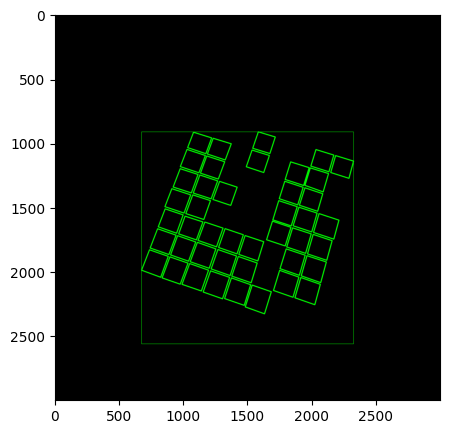

In [ ]:
all_corners = np.concatenate(valid_polygons).reshape(-1, 2)

topmost    = all_corners[np.argmin(all_corners[:, 1])]
bottommost = all_corners[np.argmax(all_corners[:, 1])]
leftmost   = all_corners[np.argmin(all_corners[:, 0])]
rightmost  = all_corners[np.argmax(all_corners[:, 0])]

top_y    = topmost[1]
bottom_y = bottommost[1]
left_x   = leftmost[0]
right_x  = rightmost[0]

# Construct 4 corners
tl = [left_x, top_y]
tr = [right_x, top_y]
br = [right_x, bottom_y]
bl = [left_x, bottom_y]

width  = right_x - left_x
height = bottom_y - top_y
size = max(width, height)

# Recalculate corners, keeping top-left fixed
tr = [left_x + size, top_y]
br = [left_x + size, top_y + size]
bl = [left_x,        top_y + size]
tl = [left_x,        top_y]

square = np.array([tl, tr, br, bl], dtype=np.int32).reshape((-1, 1, 2))
cv2.polylines(valid_polygons_image, [square], isClosed=True, color=(0, 255, 0), thickness=2)

plt.figure(figsize=(5,5))
plt.imshow(valid_polygons_image)
plt.show()

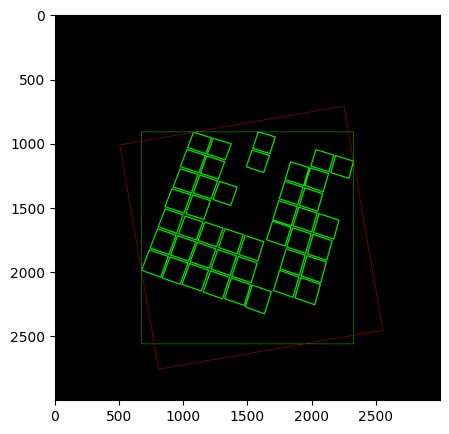

In [ ]:
def find_rotated_bounding_square(image, valid_polygons):
    # Step 1: Collect all corner points
    all_corners = np.concatenate(valid_polygons).reshape(-1, 2).astype(np.float32)

    # Step 2: Perform PCA to find dominant orientation
    mean, eigenvectors = cv2.PCACompute(all_corners, mean=None)
    centered = all_corners - mean
    rotated = centered @ eigenvectors.T  # Rotate into PCA space

    # Step 3: Axis-aligned bounding square in PCA space
    min_xy = np.min(rotated, axis=0)
    max_xy = np.max(rotated, axis=0)

    w, h = max_xy - min_xy
    size = max(w, h)  # Enforce square

    # Create square in rotated space
    square_pts = np.array([
        [min_xy[0],        min_xy[1]],
        [min_xy[0] + size, min_xy[1]],
        [min_xy[0] + size, min_xy[1] + size],
        [min_xy[0],        min_xy[1] + size]
    ])

    # Step 4: Rotate square back to original image space
    square_pts_original = square_pts @ eigenvectors + mean
    return square_pts_original.astype(np.int32)\

square_pts = find_rotated_bounding_square(image, valid_polygons)

# Draw it
cv2.polylines(valid_polygons_image, [square_pts.reshape((-1, 1, 2))], isClosed=True, color=(255, 0, 0), thickness=2)
plt.figure(figsize=(5,5))
plt.imshow(valid_polygons_image)
plt.show()